# Kaggle Project Data 3402 #

## Data Setup and Overview ##

In [1]:
from typing_extensions import dataclass_transform
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import math
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

df = pd.read_csv("training.csv")
df.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0


In [2]:
df['breast_cancer_diagnosis_code'].unique()

array(['C50919', 'C50411', 'C50112', 'C50212', '1749', 'C50912', 'C50512',
       '1744', 'C50412', 'C50812', 'C50911', 'C50312', 'C50311', 'C50111',
       '1741', 'C5091', 'C50811', '1748', 'C50511', '1743', 'C50211',
       'C50011', 'C5051', 'C50012', 'C50419', '1742', 'C50611', 'C50612',
       'C50119', 'C50819', '1746', 'C5041', 'C50619', '19881', 'C5081',
       '1745', 'C50219', 'C50319', 'C50019', 'C50519', 'C50929', 'C50021',
       'C5021', 'C5011', 'C5031', 'C509', 'C50', '1759', 'C5001',
       'C50421'], dtype=object)

In [3]:
df['metastatic_cancer_diagnosis_code'].unique()

array(['C7989', 'C773', 'C7981', 'C779', 'C7800', 'C799', 'C781', 'C786',
       'C7801', 'C7951', 'C792', 'C787', 'C771', 'C7931', 'C7982', 'C770',
       'C782', 'C7949', 'C7889', 'C7802', 'C785', 'C778', 'C7952',
       'C7940', 'C784', 'C7961', 'C772', 'C7932', 'C7970', 'C774',
       'C7911', 'C7900', 'C775', 'C7880', 'C7960', 'C7972', 'C7901',
       'C7910', 'C7839', 'C7962', 'C7971', 'C7830', 'C7919'], dtype=object)

In [4]:
selected_columns = ["patient_race", "bmi", "N02", "patient_age", "payer_type", "metastatic_cancer_diagnosis_code", "breast_cancer_diagnosis_code", "DiagPeriodL90D"]
df = df[selected_columns]
df.head()

,patient_race,bmi,N02,patient_age,payer_type,metastatic_cancer_diagnosis_code,breast_cancer_diagnosis_code,DiagPeriodL90D
0,NaN,NaN,18.606528,84,MEDICAID,C7989,C50919,1
1,White,28.49,20.113179,62,COMMERCIAL,C773,C50411,1
2,White,38.09,14.839351,43,COMMERCIAL,C773,C50112,1
3,White,NaN,15.894123,45,COMMERCIAL,C773,C50212,0
4,NaN,NaN,11.722197,55,COMMERCIAL,C773,1749,0


## Data Preprocessing ##

In [5]:
breast_cancer_diagnosis_mapping = {
    'C50919': 1, 'C50411': 2, 'C50112': 3, 'C50212': 4, '1749': 5, 'C50912': 6,
    'C50512': 7, '1744': 8, 'C50412': 9, 'C50812': 10, 'C50911': 11, 'C50312': 12,
    'C50311': 13, 'C50111': 14, '1741': 15, 'C5091': 16, 'C50811': 17, '1748': 18,
    'C50511': 19, '1743': 20, 'C50211': 21, 'C50011': 22, 'C5051': 23, 'C50012': 24,
    'C50419': 25, '1742': 26, 'C50611': 27, 'C50612': 28, 'C50119': 29, 'C50819': 30,
    '1746': 31, 'C5041': 32, 'C50619': 33, '19881': 34, 'C5081': 35, '1745': 36,
    'C50219': 37, 'C50319': 38, 'C50019': 39, 'C50519': 40, 'C50929': 41, 'C50021': 42,
    'C5021': 43, 'C5011': 44, 'C5031': 45, 'C509': 46, 'C50': 47, '1759': 48, 'C5001': 49,
    'C50421': 50
}

metastatic_cancer_diagnosis_mapping = {
    'C7989': 1, 'C773': 2, 'C7981': 3, 'C779': 4, 'C7800': 5, 'C799': 6, 'C781': 7,
    'C786': 8, 'C7801': 9, 'C7951': 10, 'C792': 11, 'C787': 12, 'C771': 13, 'C7931': 14,
    'C7982': 15, 'C770': 16, 'C782': 17, 'C7949': 18, 'C7889': 19, 'C7802': 20, 'C785': 21,
    'C778': 22, 'C7952': 23, 'C7940': 24, 'C784': 25, 'C7961': 26, 'C772': 27, 'C7932': 28,
    'C7970': 29, 'C774': 30, 'C7911': 31, 'C7900': 32, 'C775': 33, 'C7880': 34, 'C7960': 35,
    'C7972': 36, 'C7901': 37, 'C7910': 38, 'C7839': 39, 'C7962': 40, 'C7971': 41, 'C7830': 42,
    'C7919': 43
}

df['breast_cancer_diagnosis_code_encoded'] = df['breast_cancer_diagnosis_code'].map(breast_cancer_diagnosis_mapping)
df['metastatic_cancer_diagnosis_code_encoded'] = df['metastatic_cancer_diagnosis_code'].map(metastatic_cancer_diagnosis_mapping)

In [6]:
df.describe()

,bmi,N02,patient_age,DiagPeriodL90D,breast_cancer_diagnosis_code_encoded,metastatic_cancer_diagnosis_code_encoded
count,3941.000000,12877.000000,12906.000000,12906.000000,12906.000000,12906.000000
mean,28.984539,16.098988,59.183326,0.624516,8.764528,5.168449
std,5.696906,5.842501,13.335216,0.484266,6.902113,5.090029
min,14.000000,2.760371,18.000000,0.000000,1.000000,1.000000
25%,24.660000,11.280694,50.000000,0.000000,5.000000,2.000000
50%,28.190000,15.589148,59.000000,1.000000,6.000000,2.000000
75%,32.920000,20.801880,67.000000,1.000000,11.000000,10.000000
max,85.000000,31.504775,91.000000,1.000000,50.000000,43.000000


In [7]:
df_missing_data = df.isnull().sum()
print("Missing data:\n", df_missing_data)

Missing data:
 patient_race                                6385
bmi                                         8965
N02                                           29
patient_age                                    0
payer_type                                  1803
metastatic_cancer_diagnosis_code               0
breast_cancer_diagnosis_code                   0
DiagPeriodL90D                                 0
breast_cancer_diagnosis_code_encoded           0
metastatic_cancer_diagnosis_code_encoded       0
dtype: int64


In [8]:
columns_to_drop = ["patient_race", "bmi"]
df.drop(columns=columns_to_drop, inplace=True)
df.dropna(inplace=True)

In [9]:
df_missing_data = df.isnull().sum()
print("Missing data:\n", df_missing_data)

Missing data:
 N02                                         0
patient_age                                 0
payer_type                                  0
metastatic_cancer_diagnosis_code            0
breast_cancer_diagnosis_code                0
DiagPeriodL90D                              0
breast_cancer_diagnosis_code_encoded        0
metastatic_cancer_diagnosis_code_encoded    0
dtype: int64


In [10]:
payer_type = {
    "COMMERCIAL": 1,
    "MEDICAID": 2,
    "MEDICARE ADVANTAGE": 3
}

df['payer_type_encoded'] = df['payer_type'].map(payer_type)
df.drop(columns=['payer_type'], inplace=True)

## Data Visulatization ##

In [11]:
df.describe()

,N02,patient_age,DiagPeriodL90D,breast_cancer_diagnosis_code_encoded,metastatic_cancer_diagnosis_code_encoded,payer_type_encoded
count,11080.000000,11080.000000,11080.000000,11080.000000,11080.000000,11080.000000
mean,15.999461,59.556408,0.611372,8.780957,5.122563,1.682220
std,5.762922,13.271121,0.487461,6.901832,5.091292,0.817275
min,2.760371,18.000000,0.000000,1.000000,1.000000,1.000000
25%,11.311780,51.000000,0.000000,5.000000,2.000000,1.000000
50%,15.353777,59.000000,1.000000,6.000000,2.000000,1.000000
75%,20.491883,67.000000,1.000000,11.000000,10.000000,2.000000
max,31.504775,91.000000,1.000000,50.000000,43.000000,3.000000


In [12]:
df = df[['N02', 'patient_age', 'metastatic_cancer_diagnosis_code_encoded', 'breast_cancer_diagnosis_code_encoded', 'payer_type_encoded', 'DiagPeriodL90D']]

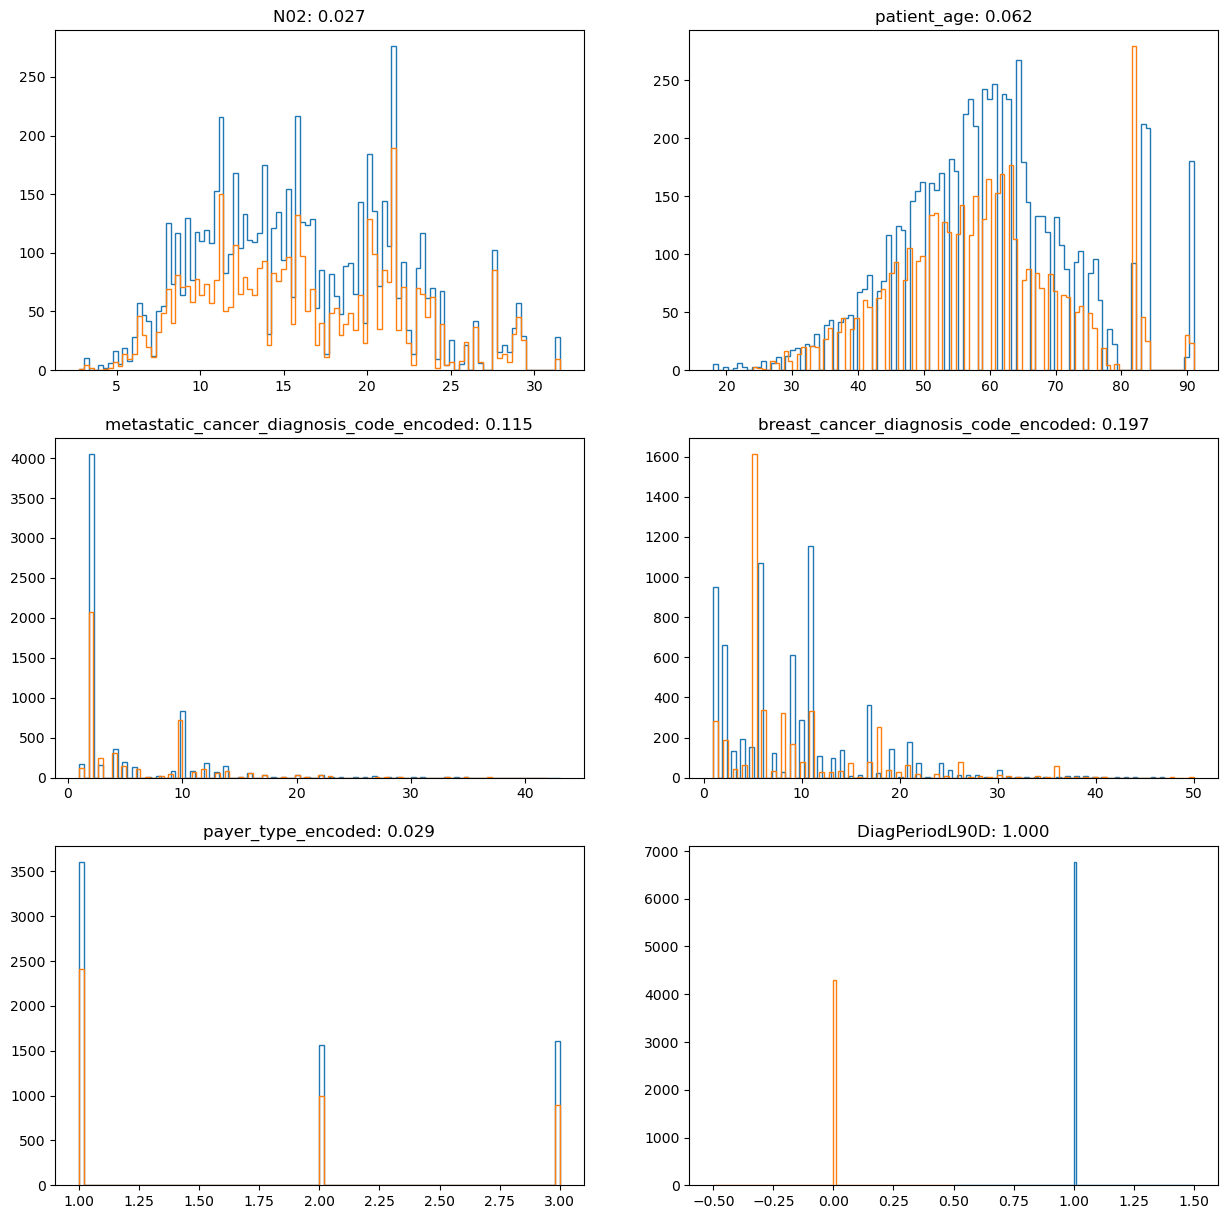

In [13]:
def compare_features(df, target, logscale=False):
    df_0=df[df[target]==0]
    df_1=df[df[target]==1]

    n=df.shape[1]
    X=math.ceil(math.sqrt(n))
    Y=math.floor(math.sqrt(n))
    if X*Y<n: Y+=1

    plt.figure(figsize=(15,15))

    for i,col in enumerate(df):
        KS_test=scipy.stats.kstest(df_0[col],df_1[col]).statistic
        KS_test_str="{KS:.3f}".format(KS=KS_test)
        
        plt.subplot(X,Y,i+1)
        plt.title(col +': '+ KS_test_str)
        if logscale: plt.yscale('log')
        plt.hist(df_1[col].dropna(), bins=100, histtype='step', label='success', stacked=True)
        plt.hist(df_0[col].dropna(), bins=100, histtype='step', label='fail', stacked=True)

compare_features(df, 'DiagPeriodL90D', logscale=False)

## Data Modeling ##

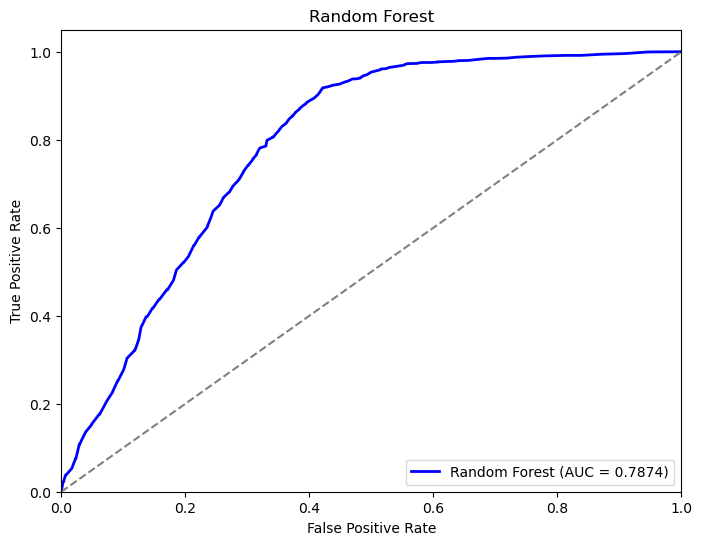

In [14]:
X = df[['metastatic_cancer_diagnosis_code_encoded', 'breast_cancer_diagnosis_code_encoded','N02', 'patient_age', 'payer_type_encoded']]
y = df['DiagPeriodL90D']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=42)

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

rf_probabilities = rf_classifier.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probabilities)
rf_auc = auc(rf_fpr, rf_tpr)

plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, color='blue', lw=2, label=f'Random Forest (AUC = {rf_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest')
plt.legend(loc='lower right')
plt.show()

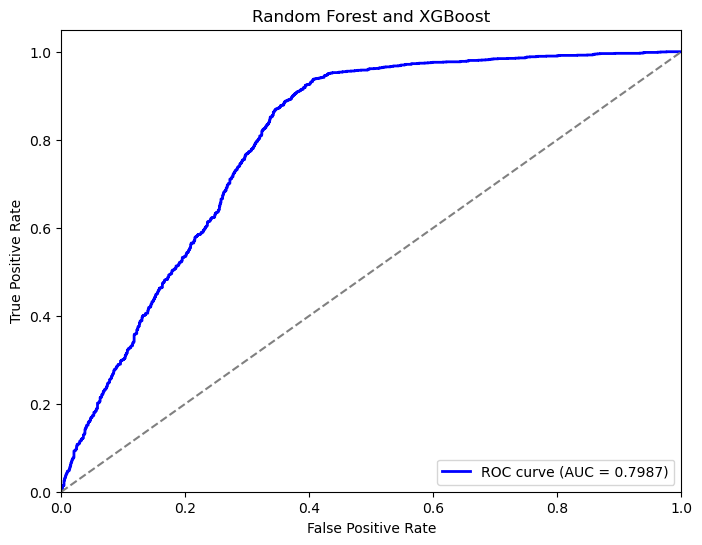

In [15]:
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)

ensemble_model_rf_xgb = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model)], voting='soft')
ensemble_model_rf_xgb.fit(X_train, y_train)

y_prob_rf_xgb = ensemble_model_rf_xgb.predict_proba(X_test)[:, 1]
fpr_rf_xgb, tpr_rf_xgb, thresholds_rf_xgb = roc_curve(y_test, y_prob_rf_xgb)
auc_rf_xgb = auc(fpr_rf_xgb, tpr_rf_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_xgb, tpr_rf_xgb, color='blue', lw=2, label='ROC curve (AUC = %0.4f)' % auc_rf_xgb)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest and XGBoost')
plt.legend(loc='lower right')
plt.show()

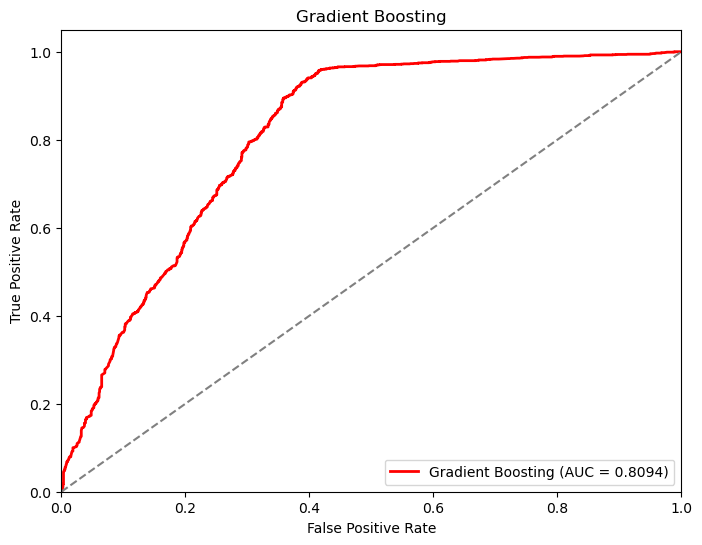

In [16]:
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)

gb_probabilities = gb_classifier.predict_proba(X_test)[:, 1]
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_probabilities)
gb_auc = auc(gb_fpr, gb_tpr)

plt.figure(figsize=(8, 6))
plt.plot(gb_fpr, gb_tpr, color='red', lw=2, label=f'Gradient Boosting (AUC = {gb_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting')
plt.legend(loc='lower right')
plt.show()

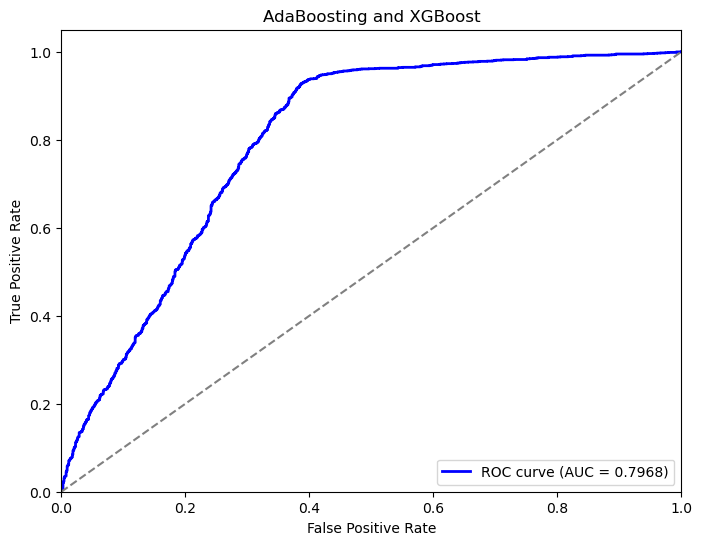

In [17]:
boost_model = AdaBoostClassifier(random_state=42)
xgb_model = xgb.XGBClassifier()

ensemble_model_boost_xgb = VotingClassifier(estimators=[('boost', boost_model), ('xgb', xgb_model)], voting='soft')
ensemble_model_boost_xgb.fit(X_train, y_train)

y_prob_boost_xgb = ensemble_model_boost_xgb.predict_proba(X_test)[:, 1]
fpr_boost_xgb, tpr_boost_xgb, thresholds_boost_xgb = roc_curve(y_test, y_prob_boost_xgb)
auc_boost_xgb = auc(fpr_boost_xgb, tpr_boost_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_boost_xgb, tpr_boost_xgb, color='blue', lw=2, label='ROC curve (AUC = %0.4f)' % auc_boost_xgb)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoosting and XGBoost')
plt.legend(loc="lower right")
plt.show()

In [18]:
cv_scores_rf_xgb = cross_val_score(ensemble_model_rf_xgb, X, y, cv=5, scoring='roc_auc')
print("Cross-validation scores for Ensemble with Random Forest and XGBoost:")
print(cv_scores_rf_xgb)
print("Mean AUC:", cv_scores_rf_xgb.mean())

cv_scores_boost_xgb = cross_val_score(ensemble_model_boost_xgb, X, y, cv=5, scoring='roc_auc')
print("\nCross-validation scores for Ensemble with Boosting and XGBoost:")
print(cv_scores_boost_xgb)
print("Mean AUC:", cv_scores_boost_xgb.mean())

Cross-validation scores for Ensemble with Random Forest and XGBoost:
[0.79346851 0.76978027 0.8010003  0.81144254 0.78795577]
Mean AUC: 0.7927294766329088

Cross-validation scores for Ensemble with Boosting and XGBoost:
[0.79076419 0.77332802 0.80770536 0.80550763 0.78885968]
Mean AUC: 0.7932329767029376


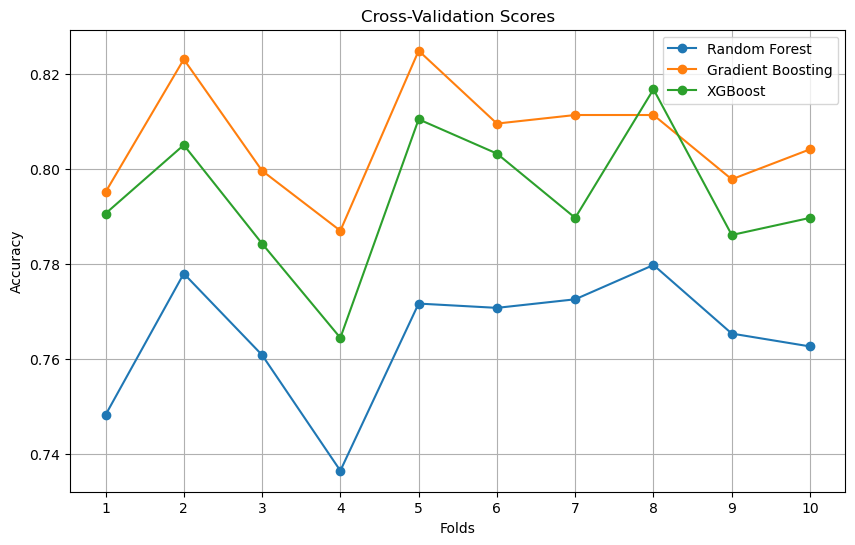

In [19]:
rf_classifier = RandomForestClassifier()
gb_classifier = GradientBoostingClassifier()
xgb_classifier = XGBClassifier()

rf_scores = cross_val_score(rf_classifier, X, y, cv=10)
gb_scores = cross_val_score(gb_classifier, X, y, cv=10)
xgb_scores = cross_val_score(xgb_classifier, X, y, cv=10)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), rf_scores, marker='o', label='Random Forest')
plt.plot(range(1, 11), gb_scores, marker='o', label='Gradient Boosting')
plt.plot(range(1, 11), xgb_scores, marker='o', label='XGBoost')
plt.title('Cross-Validation Scores')
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.show()